# Data Proposal
* Ashley Lopez
* Sandra Castro-Valadez
* Alondra Castro-Valadez
* Josue Ramirez Antonio

# Project Goal
Our project aims to identify the relationship between different player's stats and their value for when a team decides to buy that player. We'll do this by looking at several examples of good and bad transfers soccer teams have had in the last 10 years or so. We have chosen to focus on the data of ~30 transfers including about half good and half bad. We can easily add more players as we refine our project along the way

Specifically, we ask:

- Can we determine what specific stats clubs should be looking at when buying a player?
- Are there any outside factors that might deter the success of a player after a transfer that clubs should start considering?

We are using this https://rapidapi.com/api-sports/api/api-football/ API as our main data source.

# Pipeline Overview
To get df with all players of interest:
- get_team_id(team_name)
  - gives you the id of the team based on the name
- get_team_season_players(team_id, season)
  - gets all the team's players data (json) from given team id and season
- get_players_dict(team_id, season)
  - gets dict of a teams' squad from given team id an season
- get_player_id(player_name, player_team, year)
  - gets the id of a player based on the name, team, and season
- id_player_info(id)
  - gets the specific player data (json) from a specific id
- produceData(player_name, team_from, team_to, year_before, year_after)
  - populate lists with players stats for given player info
  
To get "change_df" with all transfers data that compares players first season in new team vs. their last season in prev. team
- get_player_stats_df(player_id, team1_id, team2_id, year1, year2)
  - get df with players' stats from prev. season and new season
- get_change_in_stats_df(players_df)
  - get df with "change in stats" for all players found in df with all players of interest

In [1]:
# Import packages
import requests
import pandas as pd
import json
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import pickle
import seaborn as sns

# Adding all of the id's for the teams we are using
# API stores all team id's in their website's dashboard which we could technically scrape,
# but in the best interest of time, we're currently storing these manually.

teams_ids = {'Lech Poznan' : 347, 'Borussia Dortmund' : 165,
            'Fluminense' : 124, 'Real Madrid' : 541, 'Barcelona': 529,
            'Cruz Azul' : 2295,'Feyenoord': 209, 'Manchester United': 33,
            'Monaco' : 91, 'PSG' : 85, 'Tottenham' : 47,
            'Arsenal' : 42, 'Santos': 128, 'Atletico Madrid': 530,
            'Chelsea' : 49, 'Liverpool' : 40, 'Inter Milan':  505,
            'Boca Juniors': 451 , 'Shanghai Shenhua': 833, 'Borussia Dortmund': 165,
            'Athletic Club': 531 , 'Leicester': 46, 'Juventus': 496,
            'AC Milan': 489 , 'Valencia': 532, 'Lazio': 487,
            'Newcastle': 34 , 'Eintracht Frankfurt': 169,
           'Ajax': 425, 'West Ham': 48, 'Sporting CP': 228, 'Eintracht Frankfurt': 169,
           'Roma': 497, 'Bayern Munich': 157, 'Manchester City': 50, 'Everton': 45, 'South Hampton': 41,
            "Bordeaux" : 78, "Newcastle United" :34}

def get_team_id(team_name):
    """ Get team id from team name found in our dict of team ids
        Args: team_dict (dict of teams), team_name (string)
    """
    id = teams_ids.get(team_name)
    return id

In [2]:
def get_team_season_players(team_id, season):
    """ Extract json with all teams' players info for given team and season
        Args: team_id (int), season (YYYY-YYYY)
    """
    url = f"https://api-football-v1.p.rapidapi.com/v2/players/squad/{team_id}/{season}"
    headers = {
    'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
    'x-rapidapi-key': 'cb394d9372mshfc40fe51e5602b8p1a52d4jsn29044e42587b'}
    response = requests.request("GET", url, headers=headers)
    return response.json()

In [3]:
def get_players_dict(team_id, season):
    """ Get dict of all teams' players for given team and season where
        (key, value) -> (player_name, (player_id, p_firstname, p_lastname))
        Args: team_id (int), season (YYYY-YYYY)
    """
    players_dict = {}
    json = get_team_season_players(team_id, season)['api']['players']
    for i in range(len(json)):
        players_dict[json[i]['player_name']] = (json[i]['player_id'], json[i]['firstname'], json[i]['lastname'])
    return players_dict

In [4]:
def get_player_id(player_name, player_team, season):
    """ Retrieve player id from players dict
        Args: player_name (string), player_team (string), year (YYYY-YYYY)
    """
    team_id = get_team_id(player_team)
    
    #from the id let's get the dict of all the players
    players_dict = get_players_dict(team_id, season)
    
    # id that will be returned if not found
    id = 00000
    
    for key in players_dict:
        if player_name in key:
            print('FOUND')
            value = players_dict[key]
            id = value[0]
    return id

In [5]:
def id_player_info(id):
    """ Retrieve player's info as json from their id
        Args: id (int)
    """
    url = f"https://api-football-v1.p.rapidapi.com/v2/players/player/{id}"
    headers = {
        'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
        'x-rapidapi-key': "cb394d9372mshfc40fe51e5602b8p1a52d4jsn29044e42587b"}
    response = requests.request("GET", url, headers=headers)
    return response.json()

In [6]:
players_list = []
player_id_list = []
team_to_list = []
team_to_id_list = []
team_from_list = []
team_from_id_list = []
year_before_list = []
year_after_list = []
isgood_transfer_list = []

def produceData(player_name, team_from, team_to, year_before, year_after, isgood_transfer):
    """ Populate several lists with player stats to then be used as input for data df
        Args: player_name, team_from, team_to -- all strings,
              year_before, year_after -- all 'YYYY', isgood_transfer (boolean)
    """
    # Find team ids and season
    team_1id = get_team_id(team_from)
    team_2id = get_team_id(team_to)
    season =  f'{year_before}-{year_before + 1}'
    
    # Get player's data as json
    player_id = get_player_id(player_name, team_from, season)
    player_json = id_player_info(player_id)
    player_name = player_json['api']['players'][1]['player_name']

    # Append player data to corresponding list
    players_list.append(player_name)
    player_id_list.append(player_id)
    team_to_list.append(team_to)
    team_from_list.append(team_from)
    year_before_list.append(year_before)
    year_after_list.append(year_after)
    team_from_id_list.append(team_1id)
    team_to_id_list.append(team_2id)
    isgood_transfer_list.append(isgood_transfer)

In [20]:
# Get good transfers from here: https://www.90min.com/posts/best-transfers-of-2021-ranked
# Get bad transfers from here: https://www.90min.com/posts/transfers-worst-signings-football-history-hazard-coutinho-dembele

players_dict = {'player_name': players_list, 'player_id' : player_id_list, 'team_from': team_from_list , 
             'team_to': team_to_list, 'team_from_id': team_from_id_list, 'team_to_id': team_to_id_list,
             'year_before': year_before_list, 'year_after': year_after_list, 'isgood_transfer': isgood_transfer_list}

# Generate data for good transfers:
# produceData('Ronaldo', 'Manchester United', 'Real Madrid', 2008,2010, True)
# produceData('Bale', 'Tottenham', 'Real Madrid', 2012,2014, True)
# produceData('K. Mbappé', 'Monaco', 'PSG', 2016, 2018, True)
# produceData('S. Giménez', 'Cruz Azul', 'Feyenoord', 2021, 2023, True)
# produceData('Haaland', 'Borussia Dortmund', 'Manchester City', 2021, 2023, True)
# produceData('S. Haller', 'West Ham', 'Ajax', 2020, 2022, True)
# produceData('H. Çalhanoğlu', 'AC Milan', 'Inter Milan', 2020, 2022, True)
# produceData('R. Lewandowski', 'Lech Poznan', 'Borussia Dortmund', 2009, 2011, True)
# produceData('Bruno Fernandes', 'Sporting CP', 'Manchester United', 2019, 2021, True)
# produceData('L. Suárez', 'Barcelona', 'Atletico Madrid', 2019, 2021, True)
# produceData('E. Džeko', 'Roma', 'Inter Milan', 2020, 2022, True)
# produceData('T. Kroos', 'Bayern Munich', 'Real Madrid', 2013, 2015, True)
# produceData('Mohamed Salah', 'Roma', 'Liverpool', 2016, 2018, True)
# produceData('J. Stones', 'Everton', 'Manchester City', 2015, 2017, True)
# produceData('S. Mané', 'South Hampton', 'Liverpool', 2015, 2017, True)

# For some reason the API doesn't let me generate all good and bad transfers at one, could be a limitation
# For now we'll generate individual dfs and then concatenate them

# Generate data for bad transfers: 
# produceData('O. Dembélé', 'Borussia Dortmund', 'Barcelona', 2016, 2018, False)
# produceData('A. Griezmann', 'Atletico Madrid', 'Barcelona', 2018, 2020, False)
# produceData('E. Hazard', 'Chelsea', 'Real Madrid', 2018, 2020, False)
# produceData('Philippe Coutinho', 'Liverpool', 'Barcelona', 2017, 2019, False)
# produceData('R. Lukaku', 'Inter Milan', 'Chelsea', 2020, 2022, False)
# produceData('Álvaro Morata', 'Real Madrid', 'Chelsea', 2016, 2018, False)
# produceData('S. Haller', 'Eintracht Frankfurt', 'West Ham', 2018, 2020, False)
# produceData('Z. Ibrahimović', 'Inter Milan', 'Barcelona', 2008, 2010, False)
# produceData('L. Jović', 'Eintracht Frankfurt', 'Real Madrid', 2020, 2022, False)
# produceData('A. Carroll', 'Newcastle United', 'Liverpool', 2009, 2011, False)
# produceData('Andriy Shevchenko', 'AC Milan', 'Chelsea', 2005, 2007, False)
# produceData('P. Pogba', 'Juventus', 'Manchester United', 2015, 2017, False)
# produceData('A. Sánchez', 'Arsenal', 'Manchester United', 2017, 2019, False)

In [8]:
with open('dct2_bad.pkl', 'wb') as f:
    pickle.dump(players_dict, f)

In [3]:
with open('players_dict.pkl', 'rb') as f:
    dct1 = pickle.load(f)

In [12]:
# Current transfers data -- will add more as needed for ML algorithm
good_transfers_df = pd.DataFrame.from_dict(dct1)
bad_transfers_df = pd.DataFrame.from_dict(players_dict)
transfers_df = pd.concat([good_transfers_df, bad_transfers_df], ignore_index=True)
transfers_df

,player_name,player_id,team_from,team_to,team_from_id,team_to_id,year_before,year_after,isgood_transfer
0,Cristiano Ronaldo,874,Manchester United,Real Madrid,33,541,2008,2010,True
1,G. Bale,758,Tottenham,Real Madrid,47,541,2012,2014,True
2,K. Mbappé,278,Monaco,PSG,91,85,2016,2018,True
3,S. Giménez,94562,Cruz Azul,Feyenoord,2295,209,2021,2023,True
4,E. Haaland,1100,Borussia Dortmund,Manchester City,165,50,2021,2023,True
5,S. Haller,1826,West Ham,Ajax,48,425,2020,2022,True
6,H. Çalhanoğlu,1640,AC Milan,Inter Milan,489,505,2020,2022,True
7,R. Lewandowski,521,Lech Poznan,Borussia Dortmund,347,165,2009,2011,True
8,Bruno Fernandes,1485,Sporting CP,Manchester United,228,33,2019,2021,True
9,L. Suárez,157,Barcelona,Atletico Madrid,529,530,2019,2021,True


In [177]:
def get_player_stats_df(player_id, team1_id, team2_id, year1, year2):
    """ Constructs df with player's stats from prev. and new teams' appearances
        Args: player_id, team1_id, team2_id -- all ints, year1, year2 all 'YYYY'
    """
    url1 = f"https://api-football-v1.p.rapidapi.com/v3/players?id={player_id}&season={year1}"
    url2 = f"https://api-football-v1.p.rapidapi.com/v3/players?id={player_id}&season={year2}"
    headers = {
            'x-rapidapi-host': "api-football-v1.p.rapidapi.com",
            'x-rapidapi-key': 'cb394d9372mshfc40fe51e5602b8p1a52d4jsn29044e42587b'}
    response1 = requests.request("GET", url1, headers=headers).json()
    response2 = requests.request("GET", url2, headers=headers).json()
    
    # Remove irrelevant cols
    columns_to_remove = ['team.logo', 'league.id', 'league.logo', 'league.flag', 'games.number', 'games.position']
    
    # Get dfs from jsons
    df = pd.DataFrame()
    if 'response' in response1.keys() and 'response' in response2.keys():
        df1 = pd.json_normalize(response1['response'][0]['statistics'])
        df1 = df1[df1['team.id'] == team1_id]
        df2 = pd.json_normalize(response2['response'][0]['statistics'])
        df2 = df2[df2['team.id'] == team2_id]

        # Combine dfs
        df = pd.concat([df1, df2], ignore_index=True)
        df = df.drop(columns=columns_to_remove)
    return df

In [178]:
def get_change_in_stats_df(players_df):
    """ Construct df with player's change (new_team stats - old_team stats) in stats to be used as features
        Args: playersdf (df with all players of interest)
    """
    change_df = pd.DataFrame()
    for idx, row in players_df.iterrows():
        p_id = row['player_id']
        team_fromid = row['team_from_id']
        team_toid = row['team_to_id']
        year_before = row['year_before']
        year_after = row['year_after']
        
        # Get df with players' stats for each player (only keeping numeric features)
        df = get_player_stats_df(p_id, team_fromid, team_toid, year_before, year_after)
#         print(p_id, team_fromid, team_toid)
#         display(df)
        numeric_df = df.select_dtypes(include=[np.number])
        
        # Group by team ids to separate prev. team stats from new team stats
        summed_df = numeric_df.groupby('team.id').sum().reset_index()

        # Subtract the "before team" stats from the "after team" stats
        before_team_stats = summed_df[summed_df['team.id'] == team_fromid].drop('team.id', axis=1)
        after_team_stats = summed_df[summed_df['team.id'] == team_toid].drop('team.id', axis=1)
        change_df = pd.concat([change_df, after_team_stats.reset_index(drop=True) - before_team_stats.reset_index(drop=True)], ignore_index=True)
    return change_df

In [34]:
change_in_stats_df = pd.concat([good_change, bad_change], ignore_index=True)
change_in_stats_df.insert(0, 'isGood_transfer', [True] * 15 + [False] * 13)
change_in_stats_df

,isGood_transfer,games.appearences,games.lineups,games.minutes,substitutes.in,substitutes.out,substitutes.bench,goals.total,cards.yellow,cards.yellowred,...,dribbles.attempts,dribbles.success,fouls.drawn,fouls.committed,penalty.won,penalty.scored,penalty.missed,goals.conceded,league.season,penalty.commited
0,True,7.0,7.0,716.0,0.0,-3.0,-1.0,30.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,3.0,0.0,13.0,3.0,3.0,6.0,-9.0,-8.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,-1.0,7.0,885.0,-8.0,-13.0,-16.0,13.0,4.0,0.0,...,50.0,24.0,22.0,10.0,-1.0,1.0,0.0,NaN,NaN,NaN
3,True,-28.0,-3.0,-973.0,-25.0,-7.0,-26.0,9.0,-5.0,-1.0,...,-19.0,-9.0,4.0,-20.0,NaN,0.0,1.0,0.0,NaN,NaN
4,True,-14.0,-11.0,-1018.0,-3.0,-5.0,-2.0,-16.0,-3.0,0.0,...,-31.0,-13.0,-6.0,-15.0,NaN,-5.0,1.0,0.0,10.0,NaN
5,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,True,12.0,9.0,473.0,3.0,11.0,4.0,-4.0,2.0,0.0,...,-40.0,-26.0,-13.0,31.0,NaN,0.0,0.0,0.0,8.0,NaN
7,True,14.0,14.0,1081.0,0.0,7.0,0.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,True,20.0,17.0,1500.0,3.0,12.0,3.0,-5.0,0.0,-1.0,...,15.0,4.0,7.0,13.0,-1.0,-7.0,2.0,0.0,NaN,NaN
9,True,7.0,-4.0,-408.0,11.0,7.0,16.0,-10.0,3.0,0.0,...,-29.0,-24.0,-11.0,2.0,NaN,1.0,1.0,0.0,NaN,NaN


In [36]:
# I think this is fine for now, but will have to see later as we progress
change_in_stats_df.dropna(how='all', inplace=True)
change_in_stats_df

,isGood_transfer,games.appearences,games.lineups,games.minutes,substitutes.in,substitutes.out,substitutes.bench,goals.total,cards.yellow,cards.yellowred,...,dribbles.attempts,dribbles.success,fouls.drawn,fouls.committed,penalty.won,penalty.scored,penalty.missed,goals.conceded,league.season,penalty.commited
0,True,7.0,7.0,716.0,0.0,-3.0,-1.0,30.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,3.0,0.0,13.0,3.0,3.0,6.0,-9.0,-8.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,-1.0,7.0,885.0,-8.0,-13.0,-16.0,13.0,4.0,0.0,...,50.0,24.0,22.0,10.0,-1.0,1.0,0.0,NaN,NaN,NaN
3,True,-28.0,-3.0,-973.0,-25.0,-7.0,-26.0,9.0,-5.0,-1.0,...,-19.0,-9.0,4.0,-20.0,NaN,0.0,1.0,0.0,NaN,NaN
4,True,-14.0,-11.0,-1018.0,-3.0,-5.0,-2.0,-16.0,-3.0,0.0,...,-31.0,-13.0,-6.0,-15.0,NaN,-5.0,1.0,0.0,10.0,NaN
5,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,True,12.0,9.0,473.0,3.0,11.0,4.0,-4.0,2.0,0.0,...,-40.0,-26.0,-13.0,31.0,NaN,0.0,0.0,0.0,8.0,NaN
7,True,14.0,14.0,1081.0,0.0,7.0,0.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,True,20.0,17.0,1500.0,3.0,12.0,3.0,-5.0,0.0,-1.0,...,15.0,4.0,7.0,13.0,-1.0,-7.0,2.0,0.0,NaN,NaN
9,True,7.0,-4.0,-408.0,11.0,7.0,16.0,-10.0,3.0,0.0,...,-29.0,-24.0,-11.0,2.0,NaN,1.0,1.0,0.0,NaN,NaN


In [133]:
with open('change_df.pkl', 'rb') as f:
    df = pickle.load(f)
# df = df.drop(columns=['penalty.won', 'goals.conceded', 'league.season', 'penalty.commited'])
columns_to_check = [col for col in df.columns if col != 'isGood_transfer']

# Drop rows where all NaN values are present in the specified subset of columns
df = df.dropna(subset=columns_to_check, how='all')

In [176]:
with open('all_players_df.pkl', 'rb') as f:
    df = pickle.load(f)
df

,player_name,player_id,team_from,team_to,team_from_id,team_to_id,year_before,year_after,isgood_transfer
0,Cristiano Ronaldo,874,Real Madrid,Juventus,541,496,2017,2019,True
1,G. Bale,758,Tottenham,Real Madrid,47,541,2012,2014,True
2,K. Mbappé,278,Monaco,PSG,91,85,2016,2018,True
3,S. Giménez,94562,Cruz Azul,Feyenoord,2295,209,2021,2023,True
4,E. Haaland,1100,Borussia Dortmund,Manchester City,165,50,2021,2023,True
5,S. Haller,1826,West Ham,Ajax,48,425,2020,2022,True
6,H. Çalhanoğlu,1640,AC Milan,Inter Milan,489,505,2020,2022,True
7,R. Lewandowski,521,Lech Poznan,Borussia Dortmund,347,165,2009,2011,True
8,Bruno Fernandes,1485,Sporting CP,Manchester United,228,33,2019,2021,True
9,L. Suárez,157,Barcelona,Atletico Madrid,529,530,2019,2021,True


In [185]:
df_good = df.iloc[0:10,:]
# df_good
df1 = get_change_in_stats_df(df_good)

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes

In [187]:
df_good = df.iloc[10:20,:]
# df_good
df2 = get_change_in_stats_df(df_good)

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes

In [189]:
df_good = df.iloc[20:30,:]
# df_good
df3 = get_change_in_stats_df(df_good)

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes

In [193]:
df_good = df.iloc[30:42,:]
# df_good
df4 = get_change_in_stats_df(df_good)

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\hafid\AppData\Local\Temp\ipykernel_9712\1048419485.py:25: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes

In [239]:
change_in_stats_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
change_in_stats_df.insert(0, 'isGood_transfer', [True] * 21 + [False] * 21)

# Only keeping the top 10 correlated features (plues target variable)
change_in_stats_df = change_in_stats_df[['isGood_transfer', 'dribbles.attempts', 'goals.total', 'games.lineups', 
                                         'games.minutes', 'goals.assists', 'passes.key', 'dribbles.success', 
                                         'games.appearences', 'shots.on', 'shots.total']]
# Drop any nan rows and resetting index
change_in_stats_df = change_in_stats_df.dropna()
change_in_stats_df = change_in_stats_df.reset_index(drop=True)

In [210]:
with open('change_all_df.pkl', 'wb') as f:
    pickle.dump(change_in_stats_df, f)


## Visualizations:

This correlation heatmap can help us identify which features are strongly correlated with a good or bad transfer label. Features with high positive or negative correlations can be essential factors to consider. From a quick look we see that "duels.total" and "games.lineups" have the highest corr. with the label col with a score of ~0.7.

In [227]:
change_in_stats_df

,isGood_transfer,dribbles.attempts,goals.total,games.lineups,games.minutes,goals.assists,passes.key,dribbles.success,games.appearences,shots.on,shots.total
0,True,37.0,-5.0,5.0,470.0,-4.0,6.0,20.0,4.0,-12.0,-2.0
1,True,50.0,13.0,7.0,885.0,3.0,23.0,24.0,-1.0,31.0,77.0
2,True,-14.0,12.0,0.0,-734.0,2.0,1.0,-7.0,-25.0,11.0,4.0
3,True,-31.0,-11.0,-8.0,-777.0,-3.0,-10.0,-13.0,-11.0,-12.0,-26.0
4,True,-40.0,-4.0,9.0,473.0,-1.0,-31.0,-26.0,12.0,-5.0,-16.0
5,True,15.0,-5.0,17.0,1500.0,5.0,44.0,4.0,20.0,-1.0,-13.0
6,True,-29.0,-10.0,-4.0,-408.0,-8.0,-18.0,-24.0,7.0,-25.0,-40.0
7,True,-33.0,2.0,11.0,866.0,0.0,0.0,-18.0,21.0,1.0,2.0
8,True,42.0,-3.0,2.0,236.0,11.0,88.0,33.0,0.0,8.0,31.0
9,True,107.0,9.0,14.0,1276.0,-3.0,-13.0,58.0,14.0,26.0,76.0


In [240]:
corr_mat = change_in_stats_df.corr()
fig = px.imshow(corr_mat)
fig.update_layout(title="Correlation Matrix Heatmap")
fig.show()

variable_of_interest = 'isGood_transfer'
# Get the correlations with the variable of interest and sort them
correlations_with_target = corr_mat[variable_of_interest].sort_values(ascending=False)

# Display the most correlated variables
print("Most correlated variables with", variable_of_interest, ":\n", correlations_with_target)

Most correlated variables with isGood_transfer :
 isGood_transfer      1.000000
dribbles.attempts    0.602591
goals.assists        0.571885
games.lineups        0.569492
games.minutes        0.565907
passes.key           0.565445
dribbles.success     0.558536
goals.total          0.548951
games.appearences    0.504567
shots.on             0.488683
shots.total          0.488626
Name: isGood_transfer, dtype: float64


This plot aims to help us decide if the "duels.total" variable and the target var. (isGood_transfer) var. have a linear relationship so that we can use the fact "duels.total" has a high correlation score with out target variable.
For this we did a regression plot with logistic equals true since our target variable is binary. We got a perfect separation warning indicating this variable "perfectly" predicts a good/bad transfer but I'm not sure if this is a good thing in this context. We'd like to have feedback on this so we can move forward. For now, we'll keep exploring this type of plot with other variables to see which ones could be useful when predicting whether a transfer is good or bad.

# Analysis/ML Plan:
The machine learning model we believe is most appropriate for our project is Logistic Regression. This model is well-suited for binary classification tasks, making it a good choice for determining whether a player transfer is 'good' or 'bad' based on changes in performance metrics from their initial and final seasons with their new team and the previous team, respectively. Logistic Regression assumes that the relationship between the predictor variables (performance metrics) and the binary outcome (transfer quality) is a log-odds function, resulting in an S-shaped logistic curve. However, it's important to note that this model assumes that the relationship is linear on the log-odds scale and that there is no perfect multicollinearity among the predictor variables. As we explore our data and perform feature selection, we will ensure that these assumptions hold. Our goal is to identify the most influential performance metrics that can serve as valuable indicators for teams when evaluating potential player transfers.

In [241]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

y = change_in_stats_df['isGood_transfer']
X = change_in_stats_df.drop(columns=['isGood_transfer'])

# Perform cross validation with 20% used for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3000)

# Standardized features since they're all in different scales 
# For each col, subtract mean and divide by standard deviation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Create a Logistic Regression model with L1 regularization (Lasso)
log_model = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the scaled training data
log_model.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred = log_model.predict(X_test_scaled)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the coefficients of the model after L1 regularization
print("Coefficients after L1 regularization:\n", log_model.coef_)

Accuracy: 0.8571428571428571
Coefficients after L1 regularization:
 [[0.67866505 0.76841272 0.         0.         0.         0.22041685
  0.         0.23513519 0.         0.        ]]


In [242]:
X = X[['dribbles.attempts', 'goals.total', 'passes.key', 'games.appearences']]

# Perform cross validation with 20% used for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3000)

# Standardized features since they're all in different scales 
# For each col, subtract mean and divide by standard deviation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Create a Logistic Regression model with L1 regularization (Lasso)
log_model = LogisticRegression(solver='liblinear')

# Fit the model to the scaled training data
log_model.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred = log_model.predict(X_test_scaled)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8571428571428571


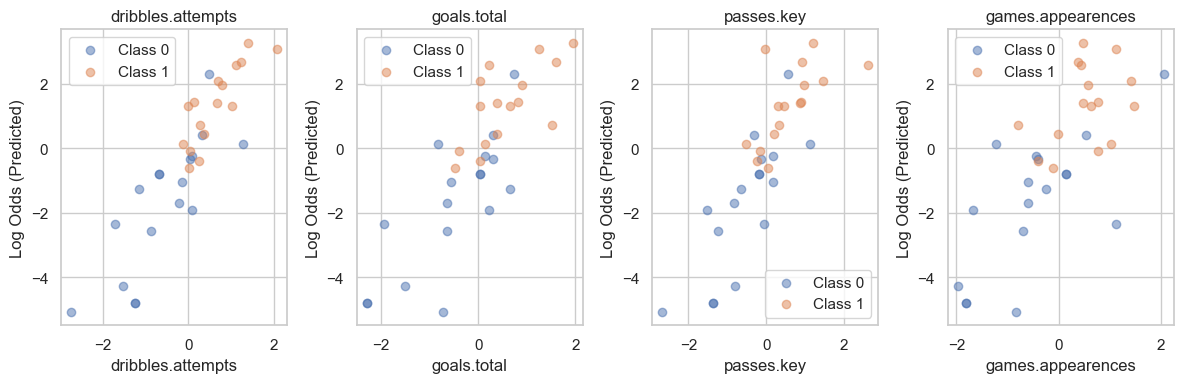

In [254]:
# Standardize full data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
features = list(X.columns)

# Fit the same model on full data
model = LogisticRegression(solver='liblinear')
model.fit(X_standardized, y)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_standardized)[:, 1]

# Plot scatter plots for each feature and each target class
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
axes = axes.flatten()

for i in range(X_standardized.shape[1]):
    for class_label in [0, 1]:  # Assuming binary classification (0: False, 1: True)
        mask = (y == class_label)
        axes[i].scatter(X_standardized[mask, i], np.log(y_pred_proba[mask] / (1 - y_pred_proba[mask])), alpha=0.5, label=f'Class {class_label}')
    
    axes[i].set_title(features[i])
    axes[i].set_xlabel(features[i])
    axes[i].set_ylabel('Log Odds (Predicted)')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [250]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)


             Feature       VIF
0  dribbles.attempts  3.612340
1        goals.total  2.508287
2         passes.key  2.834960
3  games.appearences  1.865855
